In [15]:
%load_ext autoreload

import numpy as np
import torch
import re
import pandas as pd
import pytz

from datetime import datetime
from matplotlib import pyplot as plt
from pathlib import Path


def get_time_stamp(timezone: str = "US/Eastern") -> str:
    """Get current string-like timestamp."""
    utc_now = pytz.utc.localize(datetime.utcnow())
    tz = pytz.timezone(timezone)
    utc_as_tz = utc_now.astimezone(tz)
    return f"{utc_as_tz.strftime('%m%d%y-%H%M%S')}"


ts = get_time_stamp()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
out_root = "/opt/home/mo-marl/scripts/debug/cleanrl/data_out-iter=1-islands=12/"
from_path = Path(out_root) / "df.pkl"
df = pd.read_pickle(from_path)
df = df.set_index("index")

figures_dir = Path(out_root) / ts / "figures"
if not figures_dir.exists():
    figures_dir.mkdir(parents=True)

In [17]:
rx = re.compile(r"/(\d+)/")

In [18]:
for name, row in df.iterrows():
    island_id = rx.findall(name)[0]
    df.at[name, 'island_id'] = int(island_id)

df = df.astype({
    'island_id': int,
    'epoch': int
})

In [19]:
island_ids = df['island_id'].unique()
print(island_ids)
print(df.keys())
for key in list(df.keys()):
    if 'fitness' in key:
        print(key)

[5 6 2 1 3 0 4]
Index(['add_migrants_to_buffer', 'evolve/info/team/0/boundary_penalty',
       'evolve/info/team/0/agent/adversary_0/training/kl_coeff',
       'evolve/info/team/0/minimum_ally_speed',
       'evolve/info/team/0/agent/adversary_0/boundary_penalty',
       'evolve/info/team/0/agent/agent_0/rollout/returns',
       'evolve/info/team/0/agent/adversary_0/rollout/returns',
       'evolve/info/team/0/agent/adversary_0/minimum_ally_speed',
       'evolve/info/team/0/agent/adversary_0/minimum_adversary_speed',
       'evolve/info/team/0/agent/adversary_0/training/vf_explained_var',
       'evolve/info/team/0/agent/adversary_0/closest_landmark_distance',
       'evolve/info/team/0/closest_adversary_distance',
       'evolve/info/team/0/tag_score',
       'evolve/info/team/0/closest_ally_distance',
       'evolve/info/team/0/agent/adversary_0/training/total_loss',
       'evolve/info/team/0/agent/adversary_0/training/critic_loss',
       'evolve/info/team/0/agent/adversary_0/trai

In [23]:
def plot_col(f, ax, df, island_id, key, out_dir='figures'):
    # f, ax = plt.subplots(1, 1)
    x = []
    y = []
    y_err = []
    for name, row in df[df['island_id'] == island_id].sort_values(by='epoch').iterrows():
        epoch = int(row['epoch'])
        x.append(epoch)
        data = row[key]
        if isinstance(data, float):
            y.append(data)
        else:
            data_mean = data.mean()
            data_std = data.std()
            y.append(data_mean)
            y_err.append(data_std)

    y = np.asarray(y)
    y_err = np.asarray(y_err)

    ax.plot(x, y, label=key)

    if len(y_err):
        ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)

    if True in np.isnan(y):
        ax.set_title(f"Island {int(island_id)} (NaN detected)", c='r')
    else:
        ax.set_title(f"Island {int(island_id)}")

    ax.set_xlabel('epochs')
    ax.legend()
    # plt.show()
    # plt.close()

In [24]:
max_plt_cols = 5
count = 0

for col in df.keys():
    if 'evolve' in col:
        count += 1

print("total count", count)
num_rows = count // max_plt_cols
leftover = count % max_plt_cols
print("num rows", num_rows)
print("leftover", leftover)
num_cols = max_plt_cols + bool(leftover)
print("num cols", num_cols)

total count 45
num rows 9
leftover 0
num cols 5


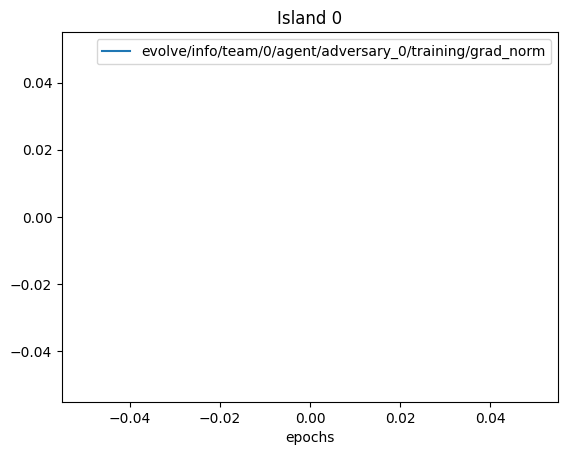

In [8]:
f, ax = plt.subplots(1, 1)

key = 'evolve/info/team/0/agent/adversary_0/training/grad_norm'
plot_col(f, ax, df, 0, key)


In [48]:
31 // 5

6

## All plots for one island

In [25]:
max_plt_cols = 5
count = 0

for col in df.keys():
    if 'evolve' in col:
        count += 1

print("total count", count)
num_rows = count // max_plt_cols
leftover = count % max_plt_cols
print("num rows", num_rows)
print("leftover", leftover)
num_cols = max_plt_cols + bool(leftover)
print("num cols", num_cols)

total count 45
num rows 9
leftover 0
num cols 5


In [26]:
figures_dir = Path(out_root) / ts / "figures"
if not figures_dir.exists():
    figures_dir.mkdir(parents=True)

for island_id, idf in df.groupby('island_id'):
    f, ax = plt.subplots(ncols=num_cols, nrows=num_rows)
    f.set_size_inches(num_cols * 6, num_rows * 7)
    
    keys = [key for key in idf.keys() if 'evolve' in key]
    print('keys', len(keys))
    col = 0
    row = 0
    for ix, key in enumerate(keys):
        # print(key)
        # print(row, col)
        axes_obj = ax[row, col]
        plot_col(f, axes_obj, idf, island_id, key)
        col = (col + 1) % (num_cols)
        if ix != 0 and col == 0:
            row += 1
    
    f.savefig(figures_dir / f"island-{int(island_id)}.pdf")
    plt.close()

keys 45
keys 45
keys 45
keys 45
keys 45
keys 45
keys 45


In [14]:
nanl = [np.nan] * 10
np.isnan(nanl)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [65]:
# from config
fitness_metric_keys = [
    "tag_score",
    "minimum_ally_speed",
    "minimum_adversary_speed",
    "closest_ally_distance",
    "closest_adversary_distance",
    "closest_landmark_distance",
    "boundary_penalty",
]

for key in list(df.keys()):
    for metric in fitness_metric_keys:
        if metric in key:
            print(key)

evolve/info/team/0/minimum_ally_speed
evolve/info/team/0/minimum_adversary_speed
evolve/info/team/0/closest_landmark_distance
evolve/info/team/0/boundary_penalty
evolve/info/team/0/closest_adversary_distance
evolve/info/team/0/tag_score
evolve/info/team/0/closest_ally_distance


## All islands for couple plot

In [32]:
max_plt_cols = 7
count = 0
island_ids = df['island_id'].unique()

keep_keys = []


search_terms = [
    'fitness',
    "tag_score",
]

for key in df.keys():
    for term in search_terms:
        if term in key:
            if key not in keep_keys:
                count += 1
                keep_keys.append(key)


print("total count", count)
count *= len(island_ids)
print("total count", count)
num_rows = max(1, count // max_plt_cols)
leftover = count % max_plt_cols
print("num rows", num_rows)
print("leftover", leftover)
num_cols = max_plt_cols + bool(leftover)
print("num cols", num_cols)
print("kept", keep_keys)

total count 4
total count 28
num rows 4
leftover 0
num cols 7
kept ['evolve/info/team/0/tag_score', 'evolve/fitness/team/0', 'evolve/info/team/0/agent/adversary_0/tag_score', 'evolve/info/team/0/agent/agent_0/tag_score']


In [33]:
figures_dir = Path(out_root) / "figures"
if not figures_dir.exists():
    figures_dir.mkdir(parents=True)

f, ax = plt.subplots(ncols=num_cols, nrows=num_rows)
f.set_size_inches(num_cols * 6, num_rows * 7)
col = 0
row = 0
counter = 0

for ix, key in enumerate(keep_keys):

    for island_id, idf in df.groupby('island_id'):

        if num_rows > 1:
            axes_obj = ax[row, col]
        else:
            axes_obj = ax[col]

        plot_col(f, axes_obj, idf, island_id, key)
        col = (col + 1) % num_cols
        if counter != 0 and col == 0:
            row += 1
        
        counter += 1
    
f.savefig(figures_dir / f"allisland-{'-'.join(search_terms)}.pdf")
plt.close()

## plot per fitness metric

In [34]:
max_plt_cols = 7

search_terms = [
    "tag_score",
    "minimum_ally_speed",
    "minimum_adversary_speed",
    "closest_ally_distance",
    "closest_adversary_distance",
    "closest_landmark_distance",
    "boundary_penalty",
]

for term in search_terms:
    print('=' * 25)
    print(f'\t{term}')
    keep_keys = []
    count = 0

    for key in df.keys():
        if term in key:
            if key not in keep_keys:
                count += 1
                keep_keys.append(key)


    print("total count", count)
    count *= len(island_ids)
    print("total count", count)
    num_rows = max(1, count // max_plt_cols)
    leftover = count % max_plt_cols
    print("num rows", num_rows)
    print("leftover", leftover)
    num_cols = max_plt_cols + bool(leftover)
    print("num cols", num_cols)
    print("kept", keep_keys)

    f, ax = plt.subplots(ncols=num_cols, nrows=num_rows)
    f.set_size_inches(num_cols * 6, num_rows * 7)
    col = 0
    row = 0
    counter = 0

    for ix, key in enumerate(keep_keys):

        for island_id, idf in df.groupby('island_id'):

            if num_rows > 1:
                axes_obj = ax[row, col]
            else:
                axes_obj = ax[col]

            plot_col(f, axes_obj, idf, island_id, key)
            col = (col + 1) % num_cols
            if counter != 0 and col == 0:
                row += 1
            
            counter += 1
        
    f.savefig(figures_dir / f"allisland-{term}.pdf")
    plt.close()

	tag_score
total count 3
total count 21
num rows 3
leftover 0
num cols 7
kept ['evolve/info/team/0/tag_score', 'evolve/info/team/0/agent/adversary_0/tag_score', 'evolve/info/team/0/agent/agent_0/tag_score']
	minimum_ally_speed
total count 3
total count 21
num rows 3
leftover 0
num cols 7
kept ['evolve/info/team/0/minimum_ally_speed', 'evolve/info/team/0/agent/adversary_0/minimum_ally_speed', 'evolve/info/team/0/agent/agent_0/minimum_ally_speed']
	minimum_adversary_speed
total count 3
total count 21
num rows 3
leftover 0
num cols 7
kept ['evolve/info/team/0/agent/adversary_0/minimum_adversary_speed', 'evolve/info/team/0/minimum_adversary_speed', 'evolve/info/team/0/agent/agent_0/minimum_adversary_speed']
	closest_ally_distance
total count 3
total count 21
num rows 3
leftover 0
num cols 7
kept ['evolve/info/team/0/closest_ally_distance', 'evolve/info/team/0/agent/adversary_0/closest_ally_distance', 'evolve/info/team/0/agent/agent_0/closest_ally_distance']
	closest_adversary_distance
tota